<a href="https://colab.research.google.com/github/faruk56-arch/PolyScopeAI/blob/master/last_updated_UNet%2B%2B_correct_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -r /content/drive/MyDrive/Medical_Image_Segmentation/modular_code/source/requirements.txt

In [1]:
import os
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from collections import OrderedDict
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf

# from train import train, validate
# from source.network import UNetPP
# from source.dataset import DataSet

In [2]:
import os
import cv2
import numpy as np
import torch.utils.data


class DataSet(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, transform=None):
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_id + self.img_ext))

        mask = []
        mask.append(cv2.imread(os.path.join(self.mask_dir, img_id + self.mask_ext), cv2.IMREAD_GRAYSCALE)[..., None])
        mask = np.dstack(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)

        return img, mask, {'img_id': img_id}



In [3]:
import torch
from torch import nn


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNetPP(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output


In [4]:
import torch


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


In [5]:
import os
import yaml
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from collections import OrderedDict
# from source.utils import iou_score, AverageMeter
from albumentations import Resize
from albumentations.augmentations import transforms
from sklearn.model_selection import train_test_split
from albumentations.core.composition import Compose, OneOf
from albumentations import RandomRotate90
# from source.network import UNetPP
# from source.dataset import DataSet


def train(deep_sup, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    model.train()

    pbar = tqdm(total=len(train_loader))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for input, target, _ in train_loader:
        input = input.to(device)
        target = target.to(device)

        # compute output
        if deep_sup:
            outputs = model(input)
            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))
        avg_meters['iou'].update(iou, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


def validate(deep_sup, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter()}

    # switch to evaluate mode
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            input = input.to(device)
            target = target.to(device)

            # compute output
            if deep_sup:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
            else:
                output = model(input)
                loss = criterion(output, target)
                iou = iou_score(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg)])


In [6]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

# from source.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose
from albumentations import Resize


val_transform = Compose([
    transforms.Resize(256, 256),
    transforms.Normalize(),
])


def image_loader(image_name):
    img = cv2.imread(image_name)
    img = val_transform(image=img)["image"]
    img = img.astype('float32') / 255
    img = img.transpose(2, 0, 1)

    return img

In [7]:
configOne = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/source/config.yaml"


In [8]:
with open(configOne) as f:
    config = yaml.load(f,Loader=yaml.Loader)

extn = config["extn"]
epochs = config["epochs"]
log_path = config["log_path"]
mask_path = config["mask_path"]
image_path = config["image_path"]
model_path = config["model_path"]

## Create log file

In [9]:
log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('val_loss', []),
    ('val_iou', []),
])

best_iou = 0
trigger = 0

## Split images into train and validation set

In [10]:
extn_ = f"*{extn}"
img_ids = glob(os.path.join(image_path, extn_))
img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
train_img_ids, val_img_ids = train_test_split(img_ids, test_size=0.1, random_state=1)
# try random state 1 and 5

## Define data transformations

In [11]:
train_transform = Compose([
    transforms.RandomRotate90(),
    transforms.Flip(),
    OneOf([
        transforms.HueSaturationValue(),
        transforms.RandomBrightness(),
        transforms.RandomContrast(),
    ], p=1),
    transforms.Resize(256, 256),
    transforms.Normalize(),
])

val_transform = Compose([
    transforms.Resize(256, 256),
    transforms.Normalize(),
])

## Create train and validation dataset

In [12]:
train_dataset = DataSet(
    img_ids=train_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=train_transform)

val_dataset = DataSet(
    img_ids=val_img_ids,
    img_dir=image_path,
    mask_dir=mask_path,
    img_ext=extn,
    mask_ext=extn,
    transform=val_transform)

## Create train and validation data loaders

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=False)
#try also batch_size 32 if stopped put 16 AGAIN

## Create the model object

In [14]:
# Create model object
model = UNetPP(1, 3, True)

# Port model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()


# Define Loss Function
criterion = nn.BCEWithLogitsLoss()
params = filter(lambda p: p.requires_grad, model.parameters())

# Define Optimizer
optimizer = optim.Adam(params, lr=1e-3, weight_decay=1e-4)
# try lr = 4 lr 2 as well

In [15]:
model_path= "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/output/models/model.pth"
log_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/output/models/logs/logs.csv"
image_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Original"
mask_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/GroundTruth"
# print("mask_path got", mask_path)

output_path = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/output/prediction.png"


In [ ]:
# # Load the model before starting the training loop
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode if not training
    print("Model loaded successfully from", model_path)
else:
    print("No pre-trained model found, proceeding with training from scratch.")

## Run the train loop

In [16]:
for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs}]')

    # train for one epoch
    train_log = train(True, train_loader, model, criterion, optimizer)
    # evaluate on validation set
    val_log = validate(True, val_loader, model, criterion)

    print('loss %.4f - iou %.4f - val_loss %.4f - val_iou %.4f'
              % (train_log['loss'], train_log['iou'], val_log['loss'], val_log['iou']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['val_loss'].append(val_log['loss'])
    log['val_iou'].append(val_log['iou'])

    pd.DataFrame(log).to_csv(log_path, index=False)

    trigger += 1

    if val_log['iou'] > best_iou:
        torch.save(model.state_dict(), model_path)
        best_iou = val_log['iou']
        print("=> saved best model")
        trigger = 0

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [0/500]


100%|██████████| 6/6 [00:52<00:00,  8.75s/it, loss=0.416, iou=1.22e-10]


loss 0.5097 - iou 0.0950 - val_loss 0.4156 - val_iou 0.0000


  0%|          | 0/48 [00:00<?, ?it/s]

=> saved best model
Epoch [1/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.3695 - iou 0.0370 - val_loss 0.4047 - val_iou 0.0103
=> saved best model
Epoch [2/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.3155 - iou 0.0145 - val_loss 0.3783 - val_iou 0.0137
=> saved best model
Epoch [3/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2894 - iou 0.0254 - val_loss 0.2948 - val_iou 0.0000
Epoch [4/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2752 - iou 0.0058 - val_loss 0.3290 - val_iou 0.0154
=> saved best model
Epoch [5/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2664 - iou 0.0135 - val_loss 0.2684 - val_iou 0.0115
Epoch [6/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2635 - iou 0.0693 - val_loss 0.2546 - val_iou 0.0033
Epoch [7/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2594 - iou 0.0611 - val_loss 0.2558 - val_iou 0.1183
=> saved best model
Epoch [8/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2590 - iou 0.0777 - val_loss 0.2629 - val_iou 0.1243
=> saved best model
Epoch [9/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2555 - iou 0.0522 - val_loss 0.2553 - val_iou 0.0654
Epoch [10/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2546 - iou 0.0576 - val_loss 0.2762 - val_iou 0.1777
=> saved best model
Epoch [11/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2522 - iou 0.1007 - val_loss 0.2526 - val_iou 0.0136
Epoch [12/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2506 - iou 0.1138 - val_loss 0.2561 - val_iou 0.0016
Epoch [13/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2482 - iou 0.1517 - val_loss 0.2682 - val_iou 0.0000
Epoch [14/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2480 - iou 0.1281 - val_loss 0.2495 - val_iou 0.0469
Epoch [15/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2434 - iou 0.1878 - val_loss 0.2424 - val_iou 0.0000
Epoch [16/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2424 - iou 0.2010 - val_loss 0.2669 - val_iou 0.2624
=> saved best model
Epoch [17/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2405 - iou 0.2152 - val_loss 0.2630 - val_iou 0.2076
Epoch [18/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2370 - iou 0.2133 - val_loss 0.2582 - val_iou 0.0131
Epoch [19/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2366 - iou 0.2302 - val_loss 0.2667 - val_iou 0.0033
Epoch [20/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2341 - iou 0.2367 - val_loss 0.3052 - val_iou 0.1411
Epoch [21/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2333 - iou 0.2447 - val_loss 0.2345 - val_iou 0.0888
Epoch [22/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2311 - iou 0.2790 - val_loss 0.3368 - val_iou 0.2458
Epoch [23/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2255 - iou 0.2975 - val_loss 0.2265 - val_iou 0.1382
Epoch [24/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2265 - iou 0.2922 - val_loss 0.3034 - val_iou 0.0463
Epoch [25/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2226 - iou 0.3157 - val_loss 0.3845 - val_iou 0.2508
Epoch [26/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2256 - iou 0.2926 - val_loss 0.2462 - val_iou 0.0936
Epoch [27/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2177 - iou 0.3481 - val_loss 0.2504 - val_iou 0.0458
Epoch [28/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2199 - iou 0.3240 - val_loss 0.2493 - val_iou 0.0210
Epoch [29/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2161 - iou 0.3421 - val_loss 0.2738 - val_iou 0.0425
Epoch [30/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2149 - iou 0.3434 - val_loss 0.2553 - val_iou 0.0389
Epoch [31/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2118 - iou 0.3870 - val_loss 0.2273 - val_iou 0.0863
Epoch [32/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2084 - iou 0.4057 - val_loss 0.2261 - val_iou 0.2340
Epoch [33/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2059 - iou 0.4109 - val_loss 0.2735 - val_iou 0.0816
Epoch [34/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2034 - iou 0.4352 - val_loss 0.2366 - val_iou 0.3883
=> saved best model
Epoch [35/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2039 - iou 0.4429 - val_loss 0.3033 - val_iou 0.0000
Epoch [36/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2019 - iou 0.4549 - val_loss 0.2701 - val_iou 0.0414
Epoch [37/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.2043 - iou 0.4338 - val_loss 0.2259 - val_iou 0.3828
Epoch [38/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1934 - iou 0.4899 - val_loss 0.2258 - val_iou 0.2596
Epoch [39/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1949 - iou 0.4933 - val_loss 0.2743 - val_iou 0.0391
Epoch [40/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1922 - iou 0.4869 - val_loss 0.2823 - val_iou 0.0321
Epoch [41/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1929 - iou 0.4907 - val_loss 0.4453 - val_iou 0.2303
Epoch [42/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1914 - iou 0.5025 - val_loss 0.3762 - val_iou 0.2319
Epoch [43/500]


100%|██████████| 6/6 [00:04<00:00,  1.35it/s, loss=0.225, iou=0.396]


loss 0.1879 - iou 0.5276 - val_loss 0.2250 - val_iou 0.3956


  0%|          | 0/48 [00:00<?, ?it/s]

=> saved best model
Epoch [44/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1870 - iou 0.5295 - val_loss 0.2355 - val_iou 0.2441
Epoch [45/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1806 - iou 0.5562 - val_loss 0.2899 - val_iou 0.0001
Epoch [46/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1847 - iou 0.5341 - val_loss 0.3769 - val_iou 0.0000
Epoch [47/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1777 - iou 0.5458 - val_loss 0.2741 - val_iou 0.1508
Epoch [48/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1798 - iou 0.5561 - val_loss 0.2995 - val_iou 0.3459
Epoch [49/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1796 - iou 0.5733 - val_loss 0.1927 - val_iou 0.5201
=> saved best model
Epoch [50/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1726 - iou 0.5943 - val_loss 0.2309 - val_iou 0.1888
Epoch [51/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1793 - iou 0.5624 - val_loss 0.2175 - val_iou 0.3411
Epoch [52/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1735 - iou 0.5863 - val_loss 0.2774 - val_iou 0.0312
Epoch [53/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1710 - iou 0.6049 - val_loss 0.2373 - val_iou 0.2769
Epoch [54/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1726 - iou 0.5920 - val_loss 0.2618 - val_iou 0.0186
Epoch [55/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1710 - iou 0.6000 - val_loss 0.3626 - val_iou 0.0000
Epoch [56/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1704 - iou 0.5978 - val_loss 0.4011 - val_iou 0.0366
Epoch [57/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1649 - iou 0.6242 - val_loss 0.2747 - val_iou 0.0468
Epoch [58/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1643 - iou 0.6243 - val_loss 0.3442 - val_iou 0.0000
Epoch [59/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1677 - iou 0.6105 - val_loss 0.3646 - val_iou 0.0000
Epoch [60/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1606 - iou 0.6336 - val_loss 0.2189 - val_iou 0.3004
Epoch [61/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1596 - iou 0.6478 - val_loss 0.2580 - val_iou 0.1154
Epoch [62/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1584 - iou 0.6447 - val_loss 0.2201 - val_iou 0.1351
Epoch [63/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1597 - iou 0.6404 - val_loss 0.3765 - val_iou 0.1838
Epoch [64/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1603 - iou 0.6495 - val_loss 0.2808 - val_iou 0.2810
Epoch [65/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1549 - iou 0.6595 - val_loss 0.2246 - val_iou 0.4279
Epoch [66/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1614 - iou 0.6503 - val_loss 0.2851 - val_iou 0.0011
Epoch [67/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1568 - iou 0.6617 - val_loss 0.2263 - val_iou 0.2081
Epoch [68/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1624 - iou 0.6262 - val_loss 0.3448 - val_iou 0.0000
Epoch [69/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1578 - iou 0.6426 - val_loss 0.3712 - val_iou 0.0000
Epoch [70/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1573 - iou 0.6525 - val_loss 0.2443 - val_iou 0.2376
Epoch [71/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1517 - iou 0.6807 - val_loss 0.2840 - val_iou 0.2490
Epoch [72/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1534 - iou 0.6801 - val_loss 0.2653 - val_iou 0.1302
Epoch [73/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1547 - iou 0.6734 - val_loss 0.2923 - val_iou 0.0887
Epoch [74/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1521 - iou 0.6836 - val_loss 0.3547 - val_iou 0.0980
Epoch [75/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1494 - iou 0.6824 - val_loss 0.5258 - val_iou 0.1978
Epoch [76/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1494 - iou 0.6835 - val_loss 0.3405 - val_iou 0.0003
Epoch [77/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1483 - iou 0.6925 - val_loss 0.2464 - val_iou 0.4070
Epoch [78/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1470 - iou 0.7017 - val_loss 0.1877 - val_iou 0.4800
Epoch [79/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1476 - iou 0.7025 - val_loss 0.2218 - val_iou 0.4555
Epoch [80/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1486 - iou 0.7037 - val_loss 0.3953 - val_iou 0.0000
Epoch [81/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1458 - iou 0.7081 - val_loss 0.2862 - val_iou 0.1222
Epoch [82/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1458 - iou 0.7054 - val_loss 0.1869 - val_iou 0.5037
Epoch [83/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1433 - iou 0.7205 - val_loss 0.3726 - val_iou 0.0000
Epoch [84/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1468 - iou 0.6984 - val_loss 0.3524 - val_iou 0.1420
Epoch [85/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1478 - iou 0.7042 - val_loss 0.2588 - val_iou 0.3044
Epoch [86/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1447 - iou 0.7065 - val_loss 0.2673 - val_iou 0.1985
Epoch [87/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1428 - iou 0.7073 - val_loss 0.4075 - val_iou 0.0000
Epoch [88/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1434 - iou 0.7071 - val_loss 0.2099 - val_iou 0.4564
Epoch [89/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1434 - iou 0.7136 - val_loss 0.5811 - val_iou 0.1071
Epoch [90/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1382 - iou 0.7490 - val_loss 0.2884 - val_iou 0.2799
Epoch [91/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1424 - iou 0.7285 - val_loss 0.2998 - val_iou 0.3426
Epoch [92/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1452 - iou 0.7090 - val_loss 0.3433 - val_iou 0.0000
Epoch [93/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1447 - iou 0.7222 - val_loss 0.2167 - val_iou 0.3855
Epoch [94/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1425 - iou 0.7185 - val_loss 0.3082 - val_iou 0.0094
Epoch [95/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1417 - iou 0.7327 - val_loss 0.2295 - val_iou 0.2778
Epoch [96/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1455 - iou 0.7082 - val_loss 0.2295 - val_iou 0.3980
Epoch [97/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1420 - iou 0.7120 - val_loss 0.2511 - val_iou 0.3765
Epoch [98/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1410 - iou 0.7205 - val_loss 0.3031 - val_iou 0.5293
=> saved best model
Epoch [99/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1388 - iou 0.7284 - val_loss 0.2579 - val_iou 0.2924
Epoch [100/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1459 - iou 0.7043 - val_loss 0.2894 - val_iou 0.1920
Epoch [101/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1401 - iou 0.7135 - val_loss 0.2363 - val_iou 0.2649
Epoch [102/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1395 - iou 0.7367 - val_loss 0.2501 - val_iou 0.2187
Epoch [103/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1367 - iou 0.7437 - val_loss 0.2764 - val_iou 0.2471
Epoch [104/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1386 - iou 0.7371 - val_loss 0.5012 - val_iou 0.2109
Epoch [105/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1415 - iou 0.7309 - val_loss 0.2772 - val_iou 0.1412
Epoch [106/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1362 - iou 0.7383 - val_loss 0.3462 - val_iou 0.0000
Epoch [107/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1368 - iou 0.7351 - val_loss 0.2538 - val_iou 0.3920
Epoch [108/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1338 - iou 0.7526 - val_loss 0.3113 - val_iou 0.0002
Epoch [109/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1370 - iou 0.7505 - val_loss 0.3181 - val_iou 0.0096
Epoch [110/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1356 - iou 0.7500 - val_loss 0.2661 - val_iou 0.1313
Epoch [111/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1323 - iou 0.7669 - val_loss 0.3429 - val_iou 0.1865
Epoch [112/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1339 - iou 0.7557 - val_loss 0.2226 - val_iou 0.3717
Epoch [113/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1334 - iou 0.7554 - val_loss 0.3126 - val_iou 0.1196
Epoch [114/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1342 - iou 0.7488 - val_loss 0.2507 - val_iou 0.2764
Epoch [115/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1358 - iou 0.7521 - val_loss 0.3887 - val_iou 0.3243
Epoch [116/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1332 - iou 0.7486 - val_loss 0.3257 - val_iou 0.0019
Epoch [117/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1337 - iou 0.7434 - val_loss 0.2871 - val_iou 0.0824
Epoch [118/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1343 - iou 0.7485 - val_loss 0.3267 - val_iou 0.1347
Epoch [119/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1313 - iou 0.7615 - val_loss 0.2348 - val_iou 0.3433
Epoch [120/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1326 - iou 0.7575 - val_loss 0.2362 - val_iou 0.2960
Epoch [121/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1330 - iou 0.7496 - val_loss 0.2901 - val_iou 0.0851
Epoch [122/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1324 - iou 0.7605 - val_loss 0.2950 - val_iou 0.0233
Epoch [123/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1320 - iou 0.7590 - val_loss 0.3429 - val_iou 0.0035
Epoch [124/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1312 - iou 0.7628 - val_loss 0.3708 - val_iou 0.0183
Epoch [125/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1333 - iou 0.7604 - val_loss 0.2188 - val_iou 0.4077
Epoch [126/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1315 - iou 0.7526 - val_loss 0.2528 - val_iou 0.1566
Epoch [127/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1310 - iou 0.7592 - val_loss 0.2424 - val_iou 0.2324
Epoch [128/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1314 - iou 0.7673 - val_loss 0.2252 - val_iou 0.3846
Epoch [129/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1330 - iou 0.7539 - val_loss 0.3908 - val_iou 0.0000
Epoch [130/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1286 - iou 0.7690 - val_loss 0.2394 - val_iou 0.2908
Epoch [131/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1290 - iou 0.7732 - val_loss 0.2275 - val_iou 0.3549
Epoch [132/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1346 - iou 0.7465 - val_loss 0.2108 - val_iou 0.3463
Epoch [133/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1292 - iou 0.7754 - val_loss 0.3723 - val_iou 0.0177
Epoch [134/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1307 - iou 0.7636 - val_loss 0.2539 - val_iou 0.3058
Epoch [135/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1321 - iou 0.7603 - val_loss 0.2453 - val_iou 0.2535
Epoch [136/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1301 - iou 0.7605 - val_loss 0.2379 - val_iou 0.2503
Epoch [137/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1284 - iou 0.7752 - val_loss 0.2688 - val_iou 0.1412
Epoch [138/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1293 - iou 0.7688 - val_loss 0.2572 - val_iou 0.2755
Epoch [139/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1293 - iou 0.7657 - val_loss 0.1881 - val_iou 0.5551
=> saved best model
Epoch [140/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1288 - iou 0.7820 - val_loss 0.1859 - val_iou 0.5492
Epoch [141/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1249 - iou 0.7881 - val_loss 0.1907 - val_iou 0.4970
Epoch [142/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1266 - iou 0.7821 - val_loss 0.3259 - val_iou 0.4343
Epoch [143/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1274 - iou 0.7730 - val_loss 0.1663 - val_iou 0.6316
=> saved best model
Epoch [144/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1261 - iou 0.7743 - val_loss 0.2915 - val_iou 0.3786
Epoch [145/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1241 - iou 0.7810 - val_loss 0.2886 - val_iou 0.1459
Epoch [146/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1247 - iou 0.7802 - val_loss 0.2946 - val_iou 0.0682
Epoch [147/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1270 - iou 0.7804 - val_loss 0.2906 - val_iou 0.1557
Epoch [148/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1269 - iou 0.7768 - val_loss 0.2708 - val_iou 0.2783
Epoch [149/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1275 - iou 0.7738 - val_loss 0.2344 - val_iou 0.3505
Epoch [150/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1275 - iou 0.7794 - val_loss 0.3191 - val_iou 0.1233
Epoch [151/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1276 - iou 0.7757 - val_loss 0.3297 - val_iou 0.0383
Epoch [152/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1241 - iou 0.7829 - val_loss 0.2586 - val_iou 0.4111
Epoch [153/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1280 - iou 0.7731 - val_loss 0.3505 - val_iou 0.1825
Epoch [154/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1288 - iou 0.7693 - val_loss 0.2326 - val_iou 0.4038
Epoch [155/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1227 - iou 0.7889 - val_loss 0.2254 - val_iou 0.3451
Epoch [156/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1249 - iou 0.7865 - val_loss 0.2638 - val_iou 0.2544
Epoch [157/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1265 - iou 0.7813 - val_loss 0.3669 - val_iou 0.0008
Epoch [158/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1233 - iou 0.8018 - val_loss 0.3497 - val_iou 0.3116
Epoch [159/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1237 - iou 0.7981 - val_loss 0.2867 - val_iou 0.1955
Epoch [160/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1275 - iou 0.7817 - val_loss 0.1904 - val_iou 0.4954
Epoch [161/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1256 - iou 0.7824 - val_loss 0.3102 - val_iou 0.2382
Epoch [162/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1256 - iou 0.7813 - val_loss 0.2480 - val_iou 0.4859
Epoch [163/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1220 - iou 0.8088 - val_loss 0.2889 - val_iou 0.3985
Epoch [164/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1225 - iou 0.7974 - val_loss 0.2470 - val_iou 0.2173
Epoch [165/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1313 - iou 0.7680 - val_loss 0.1954 - val_iou 0.6405
=> saved best model
Epoch [166/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1222 - iou 0.7996 - val_loss 0.3537 - val_iou 0.1131
Epoch [167/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1195 - iou 0.7990 - val_loss 0.3634 - val_iou 0.0351
Epoch [168/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1231 - iou 0.7952 - val_loss 0.2868 - val_iou 0.4345
Epoch [169/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1253 - iou 0.7816 - val_loss 0.2288 - val_iou 0.3525
Epoch [170/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1262 - iou 0.7811 - val_loss 0.3009 - val_iou 0.0121
Epoch [171/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1246 - iou 0.7951 - val_loss 0.4169 - val_iou 0.0157
Epoch [172/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1221 - iou 0.7933 - val_loss 0.3232 - val_iou 0.1868
Epoch [173/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1231 - iou 0.7903 - val_loss 0.2912 - val_iou 0.3030
Epoch [174/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1231 - iou 0.7912 - val_loss 0.4204 - val_iou 0.2220
Epoch [175/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1209 - iou 0.7922 - val_loss 0.2063 - val_iou 0.4330
Epoch [176/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1185 - iou 0.8076 - val_loss 0.3312 - val_iou 0.0873
Epoch [177/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1231 - iou 0.7877 - val_loss 0.2717 - val_iou 0.2013
Epoch [178/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1240 - iou 0.7938 - val_loss 0.3134 - val_iou 0.0950
Epoch [179/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1209 - iou 0.7987 - val_loss 0.2425 - val_iou 0.4232
Epoch [180/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1237 - iou 0.7939 - val_loss 0.3096 - val_iou 0.0782
Epoch [181/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1253 - iou 0.7800 - val_loss 0.6150 - val_iou 0.1417
Epoch [182/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1204 - iou 0.8039 - val_loss 0.3212 - val_iou 0.0660
Epoch [183/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1172 - iou 0.8072 - val_loss 0.3078 - val_iou 0.0988
Epoch [184/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1177 - iou 0.8175 - val_loss 0.2344 - val_iou 0.3408
Epoch [185/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1198 - iou 0.8010 - val_loss 0.3601 - val_iou 0.2143
Epoch [186/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1238 - iou 0.7867 - val_loss 0.2218 - val_iou 0.4648
Epoch [187/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1206 - iou 0.7992 - val_loss 0.2331 - val_iou 0.4225
Epoch [188/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1174 - iou 0.8133 - val_loss 0.2031 - val_iou 0.5641
Epoch [189/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1206 - iou 0.8042 - val_loss 0.2296 - val_iou 0.2813
Epoch [190/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1215 - iou 0.8017 - val_loss 0.2894 - val_iou 0.1264
Epoch [191/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1196 - iou 0.8088 - val_loss 0.2753 - val_iou 0.2234
Epoch [192/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1220 - iou 0.7929 - val_loss 0.2288 - val_iou 0.4108
Epoch [193/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1221 - iou 0.7920 - val_loss 0.1947 - val_iou 0.5148
Epoch [194/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1185 - iou 0.8075 - val_loss 0.3168 - val_iou 0.0348
Epoch [195/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1238 - iou 0.7836 - val_loss 0.2484 - val_iou 0.3038
Epoch [196/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1219 - iou 0.8006 - val_loss 0.1596 - val_iou 0.6270
Epoch [197/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1169 - iou 0.8103 - val_loss 0.2913 - val_iou 0.1183
Epoch [198/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1189 - iou 0.8066 - val_loss 0.3477 - val_iou 0.0200
Epoch [199/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1172 - iou 0.8130 - val_loss 0.3379 - val_iou 0.0100
Epoch [200/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1236 - iou 0.7888 - val_loss 0.2102 - val_iou 0.5128
Epoch [201/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1201 - iou 0.8032 - val_loss 0.2862 - val_iou 0.1364
Epoch [202/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1168 - iou 0.8170 - val_loss 0.2112 - val_iou 0.4717
Epoch [203/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1158 - iou 0.8155 - val_loss 0.2403 - val_iou 0.4219
Epoch [204/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1188 - iou 0.8095 - val_loss 0.2985 - val_iou 0.2097
Epoch [205/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1159 - iou 0.8207 - val_loss 0.2225 - val_iou 0.4201
Epoch [206/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1189 - iou 0.8047 - val_loss 0.3983 - val_iou 0.0066
Epoch [207/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1162 - iou 0.8139 - val_loss 0.2111 - val_iou 0.3558
Epoch [208/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1162 - iou 0.8174 - val_loss 0.2270 - val_iou 0.3938
Epoch [209/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1195 - iou 0.8030 - val_loss 0.1751 - val_iou 0.6045
Epoch [210/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1218 - iou 0.7892 - val_loss 0.2612 - val_iou 0.2985
Epoch [211/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1192 - iou 0.8096 - val_loss 0.2052 - val_iou 0.4255
Epoch [212/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1160 - iou 0.8189 - val_loss 0.1992 - val_iou 0.4634
Epoch [213/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1169 - iou 0.8181 - val_loss 0.3283 - val_iou 0.1479
Epoch [214/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1182 - iou 0.8036 - val_loss 0.4020 - val_iou 0.1306
Epoch [215/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1203 - iou 0.8052 - val_loss 0.2711 - val_iou 0.1163
Epoch [216/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1145 - iou 0.8243 - val_loss 0.3142 - val_iou 0.2038
Epoch [217/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1160 - iou 0.8251 - val_loss 0.3167 - val_iou 0.0977
Epoch [218/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1215 - iou 0.8067 - val_loss 0.3300 - val_iou 0.0317
Epoch [219/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1167 - iou 0.8081 - val_loss 0.2847 - val_iou 0.1465
Epoch [220/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1192 - iou 0.7999 - val_loss 0.2525 - val_iou 0.3461
Epoch [221/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1180 - iou 0.8049 - val_loss 0.2486 - val_iou 0.2728
Epoch [222/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1183 - iou 0.8147 - val_loss 0.3005 - val_iou 0.0004
Epoch [223/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1160 - iou 0.8181 - val_loss 0.2983 - val_iou 0.0939
Epoch [224/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1143 - iou 0.8295 - val_loss 0.3358 - val_iou 0.0869
Epoch [225/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1176 - iou 0.8099 - val_loss 0.2191 - val_iou 0.3919
Epoch [226/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1155 - iou 0.8179 - val_loss 0.3544 - val_iou 0.0465
Epoch [227/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1176 - iou 0.8127 - val_loss 0.3502 - val_iou 0.0865
Epoch [228/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1175 - iou 0.8203 - val_loss 0.2692 - val_iou 0.3444
Epoch [229/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1158 - iou 0.8125 - val_loss 0.2930 - val_iou 0.1881
Epoch [230/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1160 - iou 0.8201 - val_loss 0.2775 - val_iou 0.2456
Epoch [231/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1210 - iou 0.8071 - val_loss 0.2536 - val_iou 0.3529
Epoch [232/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1219 - iou 0.7966 - val_loss 0.2304 - val_iou 0.4013
Epoch [233/500]


100%|██████████| 6/6 [00:04<00:00,  1.25it/s, loss=0.154, iou=0.681]


loss 0.1162 - iou 0.8087 - val_loss 0.1541 - val_iou 0.6808


  0%|          | 0/48 [00:00<?, ?it/s]

=> saved best model
Epoch [234/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1132 - iou 0.8295 - val_loss 0.1905 - val_iou 0.5210
Epoch [235/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1158 - iou 0.8204 - val_loss 0.2306 - val_iou 0.3576
Epoch [236/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1140 - iou 0.8302 - val_loss 0.3621 - val_iou 0.0812
Epoch [237/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1142 - iou 0.8207 - val_loss 0.2375 - val_iou 0.3535
Epoch [238/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1186 - iou 0.8098 - val_loss 0.2597 - val_iou 0.2551
Epoch [239/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1142 - iou 0.8131 - val_loss 0.3125 - val_iou 0.1424
Epoch [240/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1150 - iou 0.8171 - val_loss 0.2942 - val_iou 0.1489
Epoch [241/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1193 - iou 0.7944 - val_loss 0.2752 - val_iou 0.1083
Epoch [242/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1136 - iou 0.8229 - val_loss 0.2643 - val_iou 0.2040
Epoch [243/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1143 - iou 0.8291 - val_loss 0.2763 - val_iou 0.1338
Epoch [244/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1166 - iou 0.8232 - val_loss 0.3406 - val_iou 0.0608
Epoch [245/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1182 - iou 0.8096 - val_loss 0.1736 - val_iou 0.5827
Epoch [246/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1178 - iou 0.8092 - val_loss 0.3217 - val_iou 0.0085
Epoch [247/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1174 - iou 0.8081 - val_loss 0.2563 - val_iou 0.1975
Epoch [248/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1114 - iou 0.8334 - val_loss 0.2681 - val_iou 0.3121
Epoch [249/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1145 - iou 0.8170 - val_loss 0.1977 - val_iou 0.3765
Epoch [250/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1160 - iou 0.8131 - val_loss 0.2641 - val_iou 0.2512
Epoch [251/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1179 - iou 0.8145 - val_loss 0.2713 - val_iou 0.1620
Epoch [252/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1173 - iou 0.8130 - val_loss 0.3265 - val_iou 0.3610
Epoch [253/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1137 - iou 0.8184 - val_loss 0.3139 - val_iou 0.2192
Epoch [254/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1119 - iou 0.8316 - val_loss 0.2102 - val_iou 0.4558
Epoch [255/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1127 - iou 0.8208 - val_loss 0.2794 - val_iou 0.1162
Epoch [256/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1122 - iou 0.8347 - val_loss 0.2654 - val_iou 0.2640
Epoch [257/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1145 - iou 0.8238 - val_loss 0.2303 - val_iou 0.4368
Epoch [258/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1137 - iou 0.8266 - val_loss 0.2392 - val_iou 0.3255
Epoch [259/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1112 - iou 0.8343 - val_loss 0.1795 - val_iou 0.5326
Epoch [260/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1126 - iou 0.8226 - val_loss 0.4185 - val_iou 0.2916
Epoch [261/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1131 - iou 0.8262 - val_loss 0.3356 - val_iou 0.0478
Epoch [262/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1140 - iou 0.8299 - val_loss 0.2527 - val_iou 0.3478
Epoch [263/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1127 - iou 0.8255 - val_loss 0.2726 - val_iou 0.1414
Epoch [264/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1140 - iou 0.8296 - val_loss 0.3313 - val_iou 0.2542
Epoch [265/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1105 - iou 0.8386 - val_loss 0.2003 - val_iou 0.4762
Epoch [266/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1119 - iou 0.8335 - val_loss 0.3015 - val_iou 0.2181
Epoch [267/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1118 - iou 0.8313 - val_loss 0.2323 - val_iou 0.4200
Epoch [268/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1146 - iou 0.8190 - val_loss 0.2952 - val_iou 0.3764
Epoch [269/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1146 - iou 0.8218 - val_loss 0.2277 - val_iou 0.4806
Epoch [270/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1086 - iou 0.8426 - val_loss 0.1680 - val_iou 0.5999
Epoch [271/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1120 - iou 0.8362 - val_loss 0.4098 - val_iou 0.0223
Epoch [272/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1128 - iou 0.8343 - val_loss 0.3156 - val_iou 0.1584
Epoch [273/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1162 - iou 0.8082 - val_loss 0.2300 - val_iou 0.3880
Epoch [274/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1118 - iou 0.8324 - val_loss 0.2406 - val_iou 0.4762
Epoch [275/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1118 - iou 0.8297 - val_loss 0.2922 - val_iou 0.4954
Epoch [276/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1149 - iou 0.8292 - val_loss 0.2260 - val_iou 0.3481
Epoch [277/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1162 - iou 0.8158 - val_loss 0.2694 - val_iou 0.2878
Epoch [278/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1121 - iou 0.8280 - val_loss 0.2086 - val_iou 0.4089
Epoch [279/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1105 - iou 0.8370 - val_loss 0.2254 - val_iou 0.2909
Epoch [280/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1156 - iou 0.8188 - val_loss 0.2705 - val_iou 0.1371
Epoch [281/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1143 - iou 0.8315 - val_loss 0.1641 - val_iou 0.6839
=> saved best model
Epoch [282/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1110 - iou 0.8307 - val_loss 0.2154 - val_iou 0.4287
Epoch [283/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1095 - iou 0.8398 - val_loss 0.2454 - val_iou 0.4160
Epoch [284/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1176 - iou 0.8017 - val_loss 0.3858 - val_iou 0.0039
Epoch [285/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1166 - iou 0.8237 - val_loss 0.2419 - val_iou 0.4330
Epoch [286/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1151 - iou 0.8152 - val_loss 0.2385 - val_iou 0.3034
Epoch [287/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1115 - iou 0.8375 - val_loss 0.2181 - val_iou 0.4162
Epoch [288/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1106 - iou 0.8388 - val_loss 0.4975 - val_iou 0.0081
Epoch [289/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1120 - iou 0.8343 - val_loss 0.2628 - val_iou 0.4351
Epoch [290/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1089 - iou 0.8483 - val_loss 0.4073 - val_iou 0.0000
Epoch [291/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1114 - iou 0.8331 - val_loss 0.2289 - val_iou 0.4155
Epoch [292/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1138 - iou 0.8184 - val_loss 0.3119 - val_iou 0.0789
Epoch [293/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1114 - iou 0.8338 - val_loss 0.2986 - val_iou 0.0460
Epoch [294/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1135 - iou 0.8354 - val_loss 0.3352 - val_iou 0.0814
Epoch [295/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1105 - iou 0.8304 - val_loss 0.2500 - val_iou 0.3781
Epoch [296/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1127 - iou 0.8259 - val_loss 0.2222 - val_iou 0.4122
Epoch [297/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1064 - iou 0.8471 - val_loss 0.1843 - val_iou 0.5422
Epoch [298/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1080 - iou 0.8419 - val_loss 0.1890 - val_iou 0.5725
Epoch [299/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1118 - iou 0.8332 - val_loss 0.2186 - val_iou 0.4561
Epoch [300/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1112 - iou 0.8364 - val_loss 0.2700 - val_iou 0.2716
Epoch [301/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1116 - iou 0.8226 - val_loss 0.3233 - val_iou 0.0298
Epoch [302/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1101 - iou 0.8396 - val_loss 0.3201 - val_iou 0.0053
Epoch [303/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1090 - iou 0.8365 - val_loss 0.2357 - val_iou 0.5292
Epoch [304/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1125 - iou 0.8331 - val_loss 0.3103 - val_iou 0.1697
Epoch [305/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1102 - iou 0.8368 - val_loss 0.3530 - val_iou 0.2577
Epoch [306/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1090 - iou 0.8373 - val_loss 0.2053 - val_iou 0.4629
Epoch [307/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1116 - iou 0.8242 - val_loss 0.2711 - val_iou 0.1668
Epoch [308/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1089 - iou 0.8388 - val_loss 0.2334 - val_iou 0.3346
Epoch [309/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1073 - iou 0.8396 - val_loss 0.1899 - val_iou 0.4698
Epoch [310/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1106 - iou 0.8371 - val_loss 0.4146 - val_iou 0.0542
Epoch [311/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1118 - iou 0.8323 - val_loss 0.3260 - val_iou 0.0853
Epoch [312/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1085 - iou 0.8430 - val_loss 0.1934 - val_iou 0.4707
Epoch [313/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1103 - iou 0.8371 - val_loss 0.3424 - val_iou 0.0754
Epoch [314/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1107 - iou 0.8348 - val_loss 0.2891 - val_iou 0.0349
Epoch [315/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1119 - iou 0.8310 - val_loss 0.3900 - val_iou 0.0007
Epoch [316/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1133 - iou 0.8247 - val_loss 0.3092 - val_iou 0.1140
Epoch [317/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1142 - iou 0.8245 - val_loss 0.2520 - val_iou 0.4053
Epoch [318/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1125 - iou 0.8251 - val_loss 0.2282 - val_iou 0.3094
Epoch [319/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1136 - iou 0.8174 - val_loss 0.2780 - val_iou 0.0857
Epoch [320/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1100 - iou 0.8422 - val_loss 0.2048 - val_iou 0.5059
Epoch [321/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8415 - val_loss 0.2778 - val_iou 0.1627
Epoch [322/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1090 - iou 0.8421 - val_loss 0.2929 - val_iou 0.2532
Epoch [323/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1095 - iou 0.8412 - val_loss 0.3933 - val_iou 0.0496
Epoch [324/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1095 - iou 0.8441 - val_loss 0.3188 - val_iou 0.1480
Epoch [325/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1105 - iou 0.8399 - val_loss 0.1379 - val_iou 0.7467
=> saved best model
Epoch [326/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1069 - iou 0.8546 - val_loss 0.1633 - val_iou 0.6445
Epoch [327/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1087 - iou 0.8443 - val_loss 0.3021 - val_iou 0.1631
Epoch [328/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1064 - iou 0.8487 - val_loss 0.2755 - val_iou 0.2174
Epoch [329/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1074 - iou 0.8465 - val_loss 0.3445 - val_iou 0.0795
Epoch [330/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1106 - iou 0.8307 - val_loss 0.2745 - val_iou 0.1059
Epoch [331/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1101 - iou 0.8389 - val_loss 0.2826 - val_iou 0.2676
Epoch [332/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1119 - iou 0.8343 - val_loss 0.4443 - val_iou 0.0000
Epoch [333/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1098 - iou 0.8354 - val_loss 0.2500 - val_iou 0.3580
Epoch [334/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1075 - iou 0.8448 - val_loss 0.2208 - val_iou 0.4986
Epoch [335/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1107 - iou 0.8250 - val_loss 0.3538 - val_iou 0.0956
Epoch [336/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1172 - iou 0.8067 - val_loss 0.1698 - val_iou 0.5823
Epoch [337/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1114 - iou 0.8364 - val_loss 0.1886 - val_iou 0.5852
Epoch [338/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1090 - iou 0.8327 - val_loss 0.3563 - val_iou 0.3637
Epoch [339/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1063 - iou 0.8441 - val_loss 0.1682 - val_iou 0.5969
Epoch [340/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1073 - iou 0.8398 - val_loss 0.3868 - val_iou 0.0517
Epoch [341/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1120 - iou 0.8246 - val_loss 0.2054 - val_iou 0.5018
Epoch [342/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1061 - iou 0.8508 - val_loss 0.3021 - val_iou 0.2040
Epoch [343/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1071 - iou 0.8490 - val_loss 0.2598 - val_iou 0.2383
Epoch [344/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1093 - iou 0.8273 - val_loss 0.2763 - val_iou 0.3460
Epoch [345/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1109 - iou 0.8354 - val_loss 0.3298 - val_iou 0.1273
Epoch [346/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1082 - iou 0.8431 - val_loss 0.2655 - val_iou 0.2879
Epoch [347/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1115 - iou 0.8217 - val_loss 0.3923 - val_iou 0.3344
Epoch [348/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1067 - iou 0.8476 - val_loss 0.2046 - val_iou 0.4280
Epoch [349/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1065 - iou 0.8552 - val_loss 0.1946 - val_iou 0.5968
Epoch [350/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1084 - iou 0.8406 - val_loss 0.2647 - val_iou 0.4590
Epoch [351/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1115 - iou 0.8300 - val_loss 0.2566 - val_iou 0.3764
Epoch [352/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1127 - iou 0.8118 - val_loss 0.2847 - val_iou 0.1083
Epoch [353/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1082 - iou 0.8378 - val_loss 0.2145 - val_iou 0.4792
Epoch [354/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1064 - iou 0.8406 - val_loss 0.3589 - val_iou 0.0258
Epoch [355/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1067 - iou 0.8449 - val_loss 0.3192 - val_iou 0.0967
Epoch [356/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1089 - iou 0.8354 - val_loss 0.1983 - val_iou 0.5590
Epoch [357/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8374 - val_loss 0.3213 - val_iou 0.1098
Epoch [358/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1089 - iou 0.8315 - val_loss 0.1915 - val_iou 0.4776
Epoch [359/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1054 - iou 0.8477 - val_loss 0.2211 - val_iou 0.4430
Epoch [360/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1092 - iou 0.8419 - val_loss 0.2716 - val_iou 0.2908
Epoch [361/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1122 - iou 0.8263 - val_loss 0.3056 - val_iou 0.1544
Epoch [362/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1161 - iou 0.8116 - val_loss 0.3363 - val_iou 0.0735
Epoch [363/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1102 - iou 0.8336 - val_loss 0.3850 - val_iou 0.2899
Epoch [364/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1056 - iou 0.8488 - val_loss 0.3253 - val_iou 0.1772
Epoch [365/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1083 - iou 0.8394 - val_loss 0.2893 - val_iou 0.1465
Epoch [366/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1071 - iou 0.8461 - val_loss 0.2470 - val_iou 0.2010
Epoch [367/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1097 - iou 0.8401 - val_loss 0.3698 - val_iou 0.0082
Epoch [368/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1056 - iou 0.8496 - val_loss 0.3468 - val_iou 0.0715
Epoch [369/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1050 - iou 0.8521 - val_loss 0.2296 - val_iou 0.4950
Epoch [370/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1065 - iou 0.8575 - val_loss 0.3916 - val_iou 0.0079
Epoch [371/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1073 - iou 0.8429 - val_loss 0.3311 - val_iou 0.1006
Epoch [372/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1121 - iou 0.8215 - val_loss 0.3533 - val_iou 0.1567
Epoch [373/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1072 - iou 0.8381 - val_loss 0.2038 - val_iou 0.4606
Epoch [374/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1063 - iou 0.8477 - val_loss 0.2910 - val_iou 0.2934
Epoch [375/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1048 - iou 0.8518 - val_loss 0.5314 - val_iou 0.4274
Epoch [376/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1083 - iou 0.8404 - val_loss 0.3941 - val_iou 0.0176
Epoch [377/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1067 - iou 0.8471 - val_loss 0.2465 - val_iou 0.3266
Epoch [378/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1094 - iou 0.8389 - val_loss 0.2699 - val_iou 0.5650
Epoch [379/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8365 - val_loss 0.3208 - val_iou 0.3442
Epoch [380/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1084 - iou 0.8456 - val_loss 0.2581 - val_iou 0.4766
Epoch [381/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1074 - iou 0.8412 - val_loss 0.3559 - val_iou 0.1345
Epoch [382/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1060 - iou 0.8482 - val_loss 0.2304 - val_iou 0.3717
Epoch [383/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1063 - iou 0.8510 - val_loss 0.3126 - val_iou 0.3000
Epoch [384/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1044 - iou 0.8504 - val_loss 0.3418 - val_iou 0.0946
Epoch [385/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1076 - iou 0.8404 - val_loss 0.3030 - val_iou 0.2219
Epoch [386/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1080 - iou 0.8441 - val_loss 0.7674 - val_iou 0.1227
Epoch [387/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1072 - iou 0.8423 - val_loss 0.1966 - val_iou 0.5043
Epoch [388/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1051 - iou 0.8477 - val_loss 0.3052 - val_iou 0.1691
Epoch [389/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8441 - val_loss 0.2708 - val_iou 0.2906
Epoch [390/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1071 - iou 0.8480 - val_loss 0.2165 - val_iou 0.3613
Epoch [391/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1086 - iou 0.8320 - val_loss 0.2438 - val_iou 0.3913
Epoch [392/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1081 - iou 0.8407 - val_loss 0.2600 - val_iou 0.2918
Epoch [393/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1074 - iou 0.8413 - val_loss 0.3294 - val_iou 0.0289
Epoch [394/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1117 - iou 0.8195 - val_loss 0.3048 - val_iou 0.1435
Epoch [395/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1127 - iou 0.8224 - val_loss 0.2781 - val_iou 0.1648
Epoch [396/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1067 - iou 0.8448 - val_loss 0.4630 - val_iou 0.3017
Epoch [397/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1070 - iou 0.8471 - val_loss 0.1380 - val_iou 0.7302
Epoch [398/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1075 - iou 0.8342 - val_loss 0.1994 - val_iou 0.4754
Epoch [399/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1069 - iou 0.8459 - val_loss 0.2591 - val_iou 0.4922
Epoch [400/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1030 - iou 0.8584 - val_loss 0.2428 - val_iou 0.2200
Epoch [401/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8510 - val_loss 0.2216 - val_iou 0.5177
Epoch [402/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1082 - iou 0.8450 - val_loss 0.2147 - val_iou 0.4141
Epoch [403/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1043 - iou 0.8543 - val_loss 0.1887 - val_iou 0.5909
Epoch [404/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1064 - iou 0.8473 - val_loss 0.1380 - val_iou 0.7114
Epoch [405/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1072 - iou 0.8372 - val_loss 0.2462 - val_iou 0.4082
Epoch [406/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1069 - iou 0.8458 - val_loss 0.2320 - val_iou 0.3784
Epoch [407/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1039 - iou 0.8520 - val_loss 0.2111 - val_iou 0.5596
Epoch [408/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1083 - iou 0.8331 - val_loss 0.2306 - val_iou 0.4574
Epoch [409/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1094 - iou 0.8416 - val_loss 0.1877 - val_iou 0.5532
Epoch [410/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1053 - iou 0.8554 - val_loss 0.2830 - val_iou 0.3303
Epoch [411/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1048 - iou 0.8540 - val_loss 0.2145 - val_iou 0.5335
Epoch [412/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1061 - iou 0.8511 - val_loss 0.2529 - val_iou 0.4047
Epoch [413/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1014 - iou 0.8685 - val_loss 0.1954 - val_iou 0.6000
Epoch [414/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1056 - iou 0.8475 - val_loss 0.2181 - val_iou 0.4842
Epoch [415/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1089 - iou 0.8401 - val_loss 0.2439 - val_iou 0.3449
Epoch [416/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1111 - iou 0.8245 - val_loss 0.4440 - val_iou 0.0401
Epoch [417/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1064 - iou 0.8497 - val_loss 0.3280 - val_iou 0.1067
Epoch [418/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1046 - iou 0.8545 - val_loss 0.2579 - val_iou 0.2803
Epoch [419/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1050 - iou 0.8483 - val_loss 0.1935 - val_iou 0.5352
Epoch [420/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1078 - iou 0.8366 - val_loss 0.3064 - val_iou 0.2765
Epoch [421/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1081 - iou 0.8391 - val_loss 0.2993 - val_iou 0.1076
Epoch [422/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1040 - iou 0.8539 - val_loss 0.1835 - val_iou 0.6156
Epoch [423/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1048 - iou 0.8600 - val_loss 0.2688 - val_iou 0.1978
Epoch [424/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8451 - val_loss 0.2861 - val_iou 0.2429
Epoch [425/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1088 - iou 0.8291 - val_loss 0.1967 - val_iou 0.5111
Epoch [426/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1093 - iou 0.8352 - val_loss 0.3250 - val_iou 0.2046
Epoch [427/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1055 - iou 0.8572 - val_loss 0.6850 - val_iou 0.1057
Epoch [428/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1044 - iou 0.8487 - val_loss 0.3648 - val_iou 0.0200
Epoch [429/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1029 - iou 0.8534 - val_loss 0.3892 - val_iou 0.1010
Epoch [430/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8471 - val_loss 0.3454 - val_iou 0.0894
Epoch [431/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1043 - iou 0.8596 - val_loss 0.2292 - val_iou 0.4500
Epoch [432/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8502 - val_loss 0.3402 - val_iou 0.0181
Epoch [433/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1108 - iou 0.8277 - val_loss 0.2338 - val_iou 0.3648
Epoch [434/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1062 - iou 0.8511 - val_loss 0.2082 - val_iou 0.5087
Epoch [435/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1083 - iou 0.8394 - val_loss 0.2894 - val_iou 0.1618
Epoch [436/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1079 - iou 0.8316 - val_loss 0.3687 - val_iou 0.3536
Epoch [437/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1086 - iou 0.8376 - val_loss 0.2316 - val_iou 0.2770
Epoch [438/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1049 - iou 0.8509 - val_loss 0.1541 - val_iou 0.6720
Epoch [439/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1099 - iou 0.8307 - val_loss 0.2672 - val_iou 0.3159
Epoch [440/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1063 - iou 0.8399 - val_loss 0.2356 - val_iou 0.2718
Epoch [441/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1065 - iou 0.8480 - val_loss 0.3030 - val_iou 0.0996
Epoch [442/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1041 - iou 0.8520 - val_loss 0.2518 - val_iou 0.3417
Epoch [443/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1069 - iou 0.8451 - val_loss 0.3398 - val_iou 0.2875
Epoch [444/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1059 - iou 0.8496 - val_loss 0.4029 - val_iou 0.0196
Epoch [445/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1035 - iou 0.8519 - val_loss 0.2263 - val_iou 0.4205
Epoch [446/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1045 - iou 0.8585 - val_loss 0.1688 - val_iou 0.6994
Epoch [447/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1075 - iou 0.8410 - val_loss 0.1392 - val_iou 0.6859
Epoch [448/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1044 - iou 0.8463 - val_loss 0.4100 - val_iou 0.0092
Epoch [449/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1053 - iou 0.8467 - val_loss 0.2259 - val_iou 0.3432
Epoch [450/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1014 - iou 0.8680 - val_loss 0.2301 - val_iou 0.4046
Epoch [451/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1049 - iou 0.8544 - val_loss 0.4007 - val_iou 0.4233
Epoch [452/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1037 - iou 0.8519 - val_loss 0.2133 - val_iou 0.4516
Epoch [453/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1028 - iou 0.8549 - val_loss 0.3466 - val_iou 0.0672
Epoch [454/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1017 - iou 0.8569 - val_loss 0.2466 - val_iou 0.4302
Epoch [455/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1100 - iou 0.8257 - val_loss 0.3114 - val_iou 0.1019
Epoch [456/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1076 - iou 0.8416 - val_loss 0.3877 - val_iou 0.2268
Epoch [457/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1061 - iou 0.8482 - val_loss 0.4363 - val_iou 0.3296
Epoch [458/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8447 - val_loss 0.3101 - val_iou 0.0104
Epoch [459/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1077 - iou 0.8434 - val_loss 0.2084 - val_iou 0.5109
Epoch [460/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1054 - iou 0.8437 - val_loss 0.7229 - val_iou 0.0026
Epoch [461/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1061 - iou 0.8368 - val_loss 0.1889 - val_iou 0.5594
Epoch [462/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1046 - iou 0.8533 - val_loss 0.2992 - val_iou 0.3241
Epoch [463/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8520 - val_loss 0.3619 - val_iou 0.1100
Epoch [464/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1032 - iou 0.8566 - val_loss 0.3591 - val_iou 0.4208
Epoch [465/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1050 - iou 0.8497 - val_loss 0.2022 - val_iou 0.5079
Epoch [466/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1073 - iou 0.8348 - val_loss 0.2335 - val_iou 0.3591
Epoch [467/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1067 - iou 0.8433 - val_loss 0.2559 - val_iou 0.2891
Epoch [468/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1065 - iou 0.8484 - val_loss 0.4033 - val_iou 0.1482
Epoch [469/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1053 - iou 0.8470 - val_loss 0.3013 - val_iou 0.2427
Epoch [470/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1091 - iou 0.8265 - val_loss 0.3190 - val_iou 0.0972
Epoch [471/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1059 - iou 0.8440 - val_loss 0.1402 - val_iou 0.7113
Epoch [472/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1050 - iou 0.8478 - val_loss 0.2431 - val_iou 0.4368
Epoch [473/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1025 - iou 0.8621 - val_loss 0.1532 - val_iou 0.6342
Epoch [474/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1050 - iou 0.8493 - val_loss 0.2496 - val_iou 0.5638
Epoch [475/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1092 - iou 0.8277 - val_loss 0.4849 - val_iou 0.3822
Epoch [476/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1070 - iou 0.8340 - val_loss 0.2949 - val_iou 0.0859
Epoch [477/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1026 - iou 0.8652 - val_loss 0.2615 - val_iou 0.2827
Epoch [478/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1028 - iou 0.8617 - val_loss 0.2248 - val_iou 0.4477
Epoch [479/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1036 - iou 0.8515 - val_loss 0.3312 - val_iou 0.2548
Epoch [480/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1031 - iou 0.8618 - val_loss 0.2735 - val_iou 0.2880
Epoch [481/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1020 - iou 0.8563 - val_loss 0.2156 - val_iou 0.6076
Epoch [482/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1064 - iou 0.8444 - val_loss 0.1938 - val_iou 0.5290
Epoch [483/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1063 - iou 0.8467 - val_loss 0.3064 - val_iou 0.2869
Epoch [484/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1100 - iou 0.8318 - val_loss 0.2613 - val_iou 0.3659
Epoch [485/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1020 - iou 0.8646 - val_loss 0.3069 - val_iou 0.2795
Epoch [486/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1036 - iou 0.8526 - val_loss 0.2397 - val_iou 0.2832
Epoch [487/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1054 - iou 0.8446 - val_loss 0.1856 - val_iou 0.5501
Epoch [488/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1033 - iou 0.8570 - val_loss 0.1799 - val_iou 0.5740
Epoch [489/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1016 - iou 0.8617 - val_loss 0.2741 - val_iou 0.3724
Epoch [490/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.0988 - iou 0.8698 - val_loss 0.1952 - val_iou 0.5479
Epoch [491/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1028 - iou 0.8566 - val_loss 0.4246 - val_iou 0.1701
Epoch [492/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1044 - iou 0.8504 - val_loss 0.2578 - val_iou 0.5196
Epoch [493/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1087 - iou 0.8371 - val_loss 0.2906 - val_iou 0.1170
Epoch [494/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1066 - iou 0.8420 - val_loss 0.2560 - val_iou 0.3027
Epoch [495/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1041 - iou 0.8466 - val_loss 0.2368 - val_iou 0.4699
Epoch [496/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1039 - iou 0.8548 - val_loss 0.2370 - val_iou 0.5815
Epoch [497/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1033 - iou 0.8565 - val_loss 0.1472 - val_iou 0.5002
Epoch [498/500]


  0%|          | 0/48 [00:00<?, ?it/s]

loss 0.1021 - iou 0.8564 - val_loss 0.2110 - val_iou 0.4034
Epoch [499/500]


100%|██████████| 6/6 [00:04<00:00,  1.33it/s, loss=0.309, iou=0.109]

loss 0.1006 - iou 0.8651 - val_loss 0.3087 - val_iou 0.1085


In [17]:
import cv2
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt

# from predict import image_loader
# from source.network import UNetPP
from argparse import ArgumentParser
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose

%matplotlib inline

## Create validation transforms

In [18]:
val_transform = Compose([
    transforms.Resize(256, 256),
    transforms.Normalize(),
])

In [19]:
configOne = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/source/config.yaml"

In [20]:
with open(configOne) as f:
    config = yaml.safe_load(f)

In [21]:
im_width = config["im_width"]
im_height = config["im_height"]
model_path = config["model_path"]
output_path = config["output_path"]

## Load the model

In [ ]:
# Create model object
model = UNetPP(1, 3, True)

# Load pre-trained weights
model.load_state_dict(torch.load(model_path))

# Port the model to GPU if it is available
if torch.cuda.is_available():
    model.cuda()

# Set model mode to evaluation
model.eval()

In [ ]:
# def display_random_samples(image_paths, num_samples=9):
#     plt.figure(figsize=(10, 10))
#     for i in range(num_samples):
#         plt.subplot(3, 3, i+1)
#         img = Image.open(random.choice(image_paths))
#         plt.imshow(img)
#         plt.axis('off')
#     plt.show()

# # Assuming your images are stored in a directory
# image_paths = glob(os.path.join(image_path, f"*{extn}"))
# display_random_samples(image_paths)

## Load the test image

In [105]:
test_img = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/Original/5.png"
# I take the image for training
image = image_loader(test_img)

# Convert the image to a batch of 1 image
image = np.expand_dims(image,0)

# Convert numpy array to torch tensor
image = torch.from_numpy(image)

In [106]:
# Port the image to GPU if it is available
if torch.cuda.is_available():
    image = image.to(device="cuda")

[link text](https://)## Make prediction

In [107]:
mask = model(image)
#genereted image

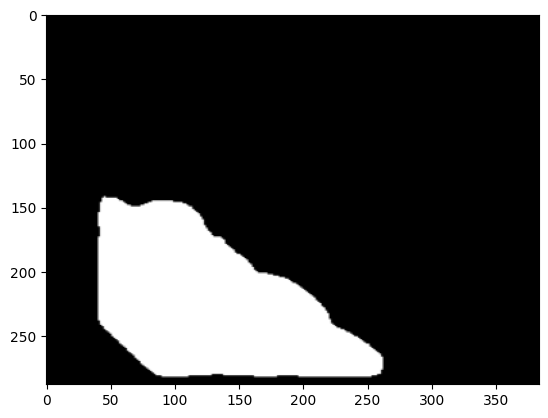

In [108]:
# here i get result of image after training data
mask = mask[-1]

# Convert torch tensor to numpy array
mask = mask.detach().cpu().numpy()

# Convert output to a 2-d array
mask = np.squeeze(np.squeeze(mask, axis=0), axis=0)

# Convert output to binary based on threshold
mask[mask > -2.5] = 255
mask[mask <= -2.5] = 0

# Resize the ouptut image to input image size
mask = cv2.resize(mask, (im_width, im_height))

# Plot the generated mask
plt.imshow(mask, cmap="gray")

## Read and plot the ground truth mask

> Add blockquote



1.   List item
2.   List item



*   List item
*   List item



---



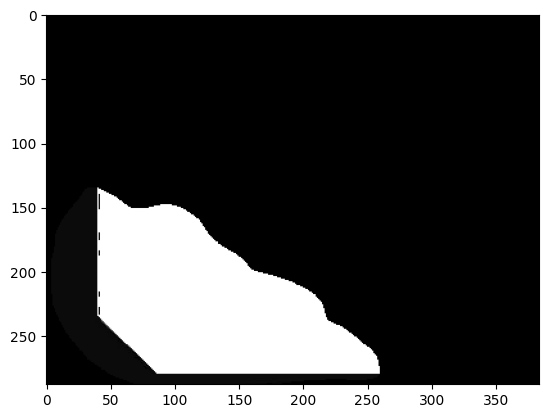

In [109]:
actual_mask = "/content/drive/MyDrive/Medical_Image_Segmentation/modular_code/input/PNG/GroundTruth/5.png"
am = plt.imread(actual_mask)
plt.imshow(am, cmap="gray")
#I should get result like this above(actuel result)